# Analyzing the MCMC Accuracy Results

## Average WIS by State
We have weekly prediction data for each state. To start comparing the results, we will plot the average of each state's scores for a visual comparison. 

In [1]:
# Create a dataframe where each state has a single average WIS score
import pandas as pd
import os

all_data = pd.DataFrame(columns=['state_code', 'state_abbrev', 'avg_wis'])

accuracy_results_path = '../mcmc_accuracy_results/'
for file_name in os.listdir(accuracy_results_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(accuracy_results_path, file_name)
        state_df = pd.read_csv(file_path)
        state_code, state_abbrev = state_df['state_code'][1], state_df['state_abbrev'][1]
        all_wis_columns = ['1wk_WIS', '2wk_WIS', '3wk_WIS', '4wk_WIS']
        combined_data = state_df[all_wis_columns].values.flatten()
        avg_wis = combined_data.mean()
        new_row = {'state_code': str(state_code).zfill(2), 'state_abbrev': state_abbrev, 'avg_wis': avg_wis}
        new_row_df = pd.DataFrame([new_row], columns=['state_code', 'state_abbrev', 'avg_wis'])
        all_data = pd.concat([all_data, new_row_df], ignore_index=True)

all_data.head()

/tmp/ipykernel_60388/2345187149.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_data = pd.concat([all_data, new_row_df], ignore_index=True)


,state_code,state_abbrev,avg_wis
0,04,AZ,321.177188
1,01,AL,76.918125
2,05,AR,81.767187
3,06,CA,440.165417
4,08,CO,104.970208


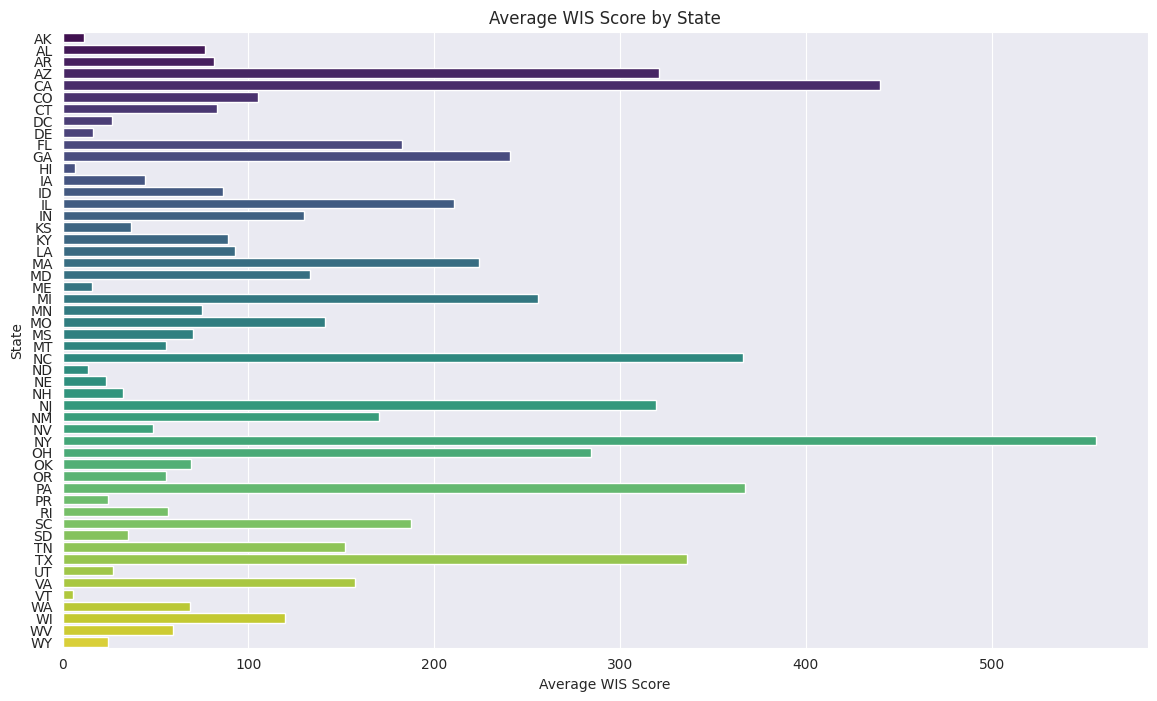

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create bar plot
all_data.sort_values(by='state_abbrev', ascending=True, inplace=True)
sns.barplot(x='avg_wis', y='state_abbrev', data=all_data, palette='viridis', hue='state_abbrev', legend=False)

# Add title and labels
plt.title('Average WIS Score by State')
plt.xlabel('Average WIS Score')
plt.ylabel('State')

# Show plot
plt.show()


Not too enlightening. Let's try to find features that are influencing the big difference in scores between states.

## Adding State Features
First, we need to add the full name of each state, because all of the new data is indexed by the full state name. 
Then, we can add features that we believe may influence the scoring. 

In [3]:
state_name_mapping = pd.read_csv('../datasets/abbr-name.csv')

all_data = pd.merge(all_data, state_name_mapping, on='state_abbrev', how='left')

all_data.head()

,state_code,state_abbrev,avg_wis,state_name
0,02,AK,11.471042,Alaska
1,01,AL,76.918125,Alabama
2,05,AR,81.767187,Arkansas
3,04,AZ,321.177188,Arizona
4,06,CA,440.165417,California


In [4]:
# Add health care expenditure data
healthcare_expenditure_df = pd.read_csv('../datasets/healthcare_expenditures.csv')

# Clean the columns names, remove Puerto Rico (no data available), and remove dollar sign.
healthcare_expenditure_df.columns = healthcare_expenditure_df.columns.str.strip()
all_data.columns = all_data.columns.str.strip()
all_data = all_data[all_data['state_abbrev'] != 'PR']
healthcare_expenditure_df = healthcare_expenditure_df[healthcare_expenditure_df['health_expenditure'].notna()]
healthcare_expenditure_df['health_expenditure'] = healthcare_expenditure_df['health_expenditure'].str.replace('$', '').astype(int)

# Join the dataframes
all_data = pd.merge(all_data, healthcare_expenditure_df, on='state_name', how='left')

all_data['state_name'] = all_data['state_name'].str.lower()

all_data.head()


,state_code,state_abbrev,avg_wis,state_name,health_expenditure
0,02,AK,11.471042,alaska,9975.0
1,01,AL,76.918125,alabama,45673.0
2,05,AR,81.767187,arkansas,28300.0
3,04,AZ,321.177188,arizona,64980.0
4,06,CA,440.165417,california,405451.0


In [5]:
# Add adults who haven't visited doctor in past year
adults_no_doctor_df = pd.read_csv('../datasets/adults_no_doctor.csv')
adults_no_doctor_df.columns=adults_no_doctor_df.columns.str.strip()
adults_no_doctor_df.drop(columns=['Male', 'Female', 'Footnotes'], inplace=True)
adults_no_doctor_df['state_name'] = adults_no_doctor_df['state_name'].str.lower()

all_data = pd.merge(all_data, adults_no_doctor_df, on='state_name', how='left')
all_data.rename(columns={'all_adults': 'adults_no_doctor_percent'}, inplace=True)

all_data.head()

,state_code,state_abbrev,avg_wis,state_name,health_expenditure,adults_no_doctor_percent
0,02,AK,11.471042,alaska,9975.0,0.095
1,01,AL,76.918125,alabama,45673.0,0.113
2,05,AR,81.767187,arkansas,28300.0,0.107
3,04,AZ,321.177188,arizona,64980.0,0.098
4,06,CA,440.165417,california,405451.0,0.090


In [6]:
# Add hospital beds per capita data
hosp_beds_per_cap_df = pd.read_csv('../datasets/hospital_beds_per_capita.csv')
hosp_beds_per_cap_df.drop(columns=['State/Local Government', 'Non-Profit', 'For-Profit'], inplace=True)
hosp_beds_per_cap_df.columns = hosp_beds_per_cap_df.columns.str.strip()
hosp_beds_per_cap_df['state_name'] = hosp_beds_per_cap_df['state_name'].str.lower()

all_data = pd.merge(all_data, hosp_beds_per_cap_df, on='state_name', how='left')

all_data.head()

,state_code,state_abbrev,avg_wis,state_name,health_expenditure,adults_no_doctor_percent,total_beds_per_cap
0,02,AK,11.471042,alaska,9975.0,0.095,2.23
1,01,AL,76.918125,alabama,45673.0,0.113,3.07
2,05,AR,81.767187,arkansas,28300.0,0.107,3.13
3,04,AZ,321.177188,arizona,64980.0,0.098,1.99
4,06,CA,440.165417,california,405451.0,0.090,1.89


In [7]:
# Add state populations
pop_by_state_df = pd.read_csv('../datasets/us_pop_by_state.csv')
pop_by_state_df.drop(columns=['rank', 'state', 'percent_of_total'], inplace=True)
pop_by_state_df.columns = pop_by_state_df.columns.str.strip()

all_data = pd.merge(all_data, pop_by_state_df, on='state_abbrev', how='left')

all_data.head()

,state_code,state_abbrev,avg_wis,state_name,health_expenditure,adults_no_doctor_percent,total_beds_per_cap,population
0,02,AK,11.471042,alaska,9975.0,0.095,2.23,733391
1,01,AL,76.918125,alabama,45673.0,0.113,3.07,5024279
2,05,AR,81.767187,arkansas,28300.0,0.107,3.13,3011524
3,04,AZ,321.177188,arizona,64980.0,0.098,1.99,7151502
4,06,CA,440.165417,california,405451.0,0.090,1.89,39538223


In [14]:
# Convert health_expenditure to per capita using population
all_data['health_expend_per_cap'] = all_data['health_expenditure'] / all_data['population']
all_data.drop('health_expenditure', axis=1, inplace=True)

all_data.head()

,state_code,state_abbrev,avg_wis,state_name,adults_no_doctor_percent,total_beds_per_cap,population,health_expend_per_cap
0,02,AK,11.471042,alaska,0.095,2.23,733391,0.013601
1,01,AL,76.918125,alabama,0.113,3.07,5024279,0.009090
2,05,AR,81.767187,arkansas,0.107,3.13,3011524,0.009397
3,04,AZ,321.177188,arizona,0.098,1.99,7151502,0.009086
4,06,CA,440.165417,california,0.090,1.89,39538223,0.010255


ValueError: array must not contain infs or NaNs

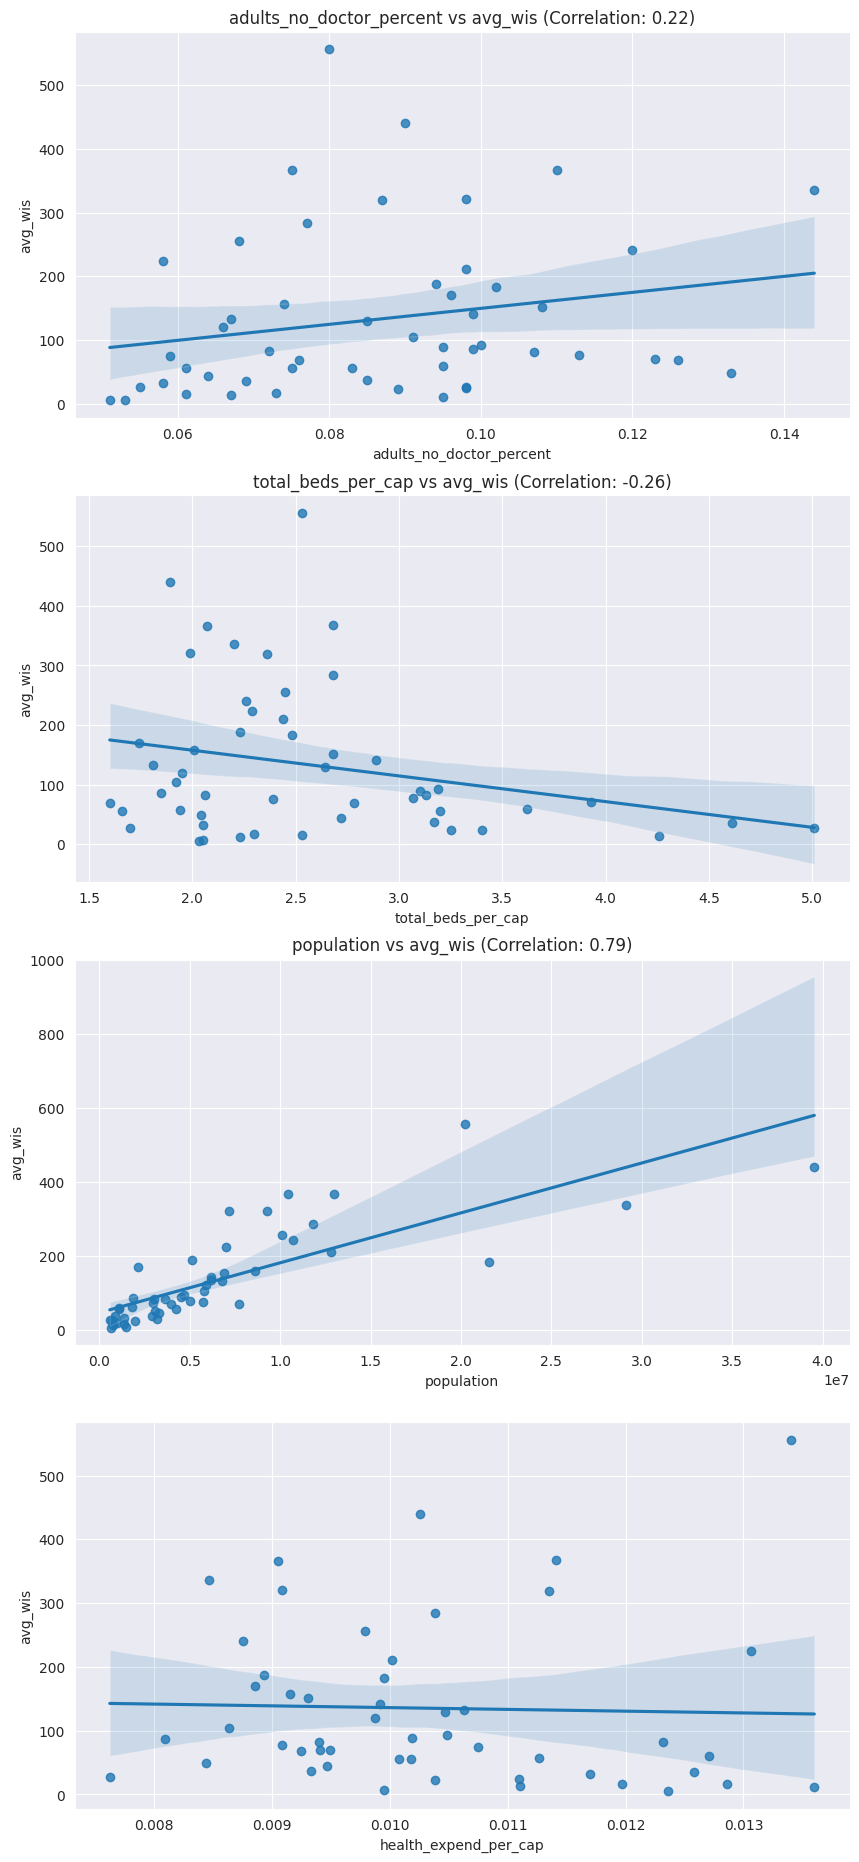

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

target_variable = 'avg_wis'
features = all_data.drop(columns=['state_code', 'state_abbrev', 'state_name', target_variable])

plt.figure(figsize=(10, 6 * len(features)))

# Loop through each feature and create a scatter plot with regression line and correlation coefficient
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.regplot(data=all_data, x=feature, y=target_variable)
    
    # Calculate the correlation coefficient
    corr, _ = pearsonr(all_data[feature], all_data[target_variable])
    
    # Add title and correlation coefficient to the plot
    plt.title(f'{feature} vs {target_variable} (Correlation: {corr:.2f})')
    plt.xlabel(feature)
    plt.ylabel(target_variable)

    
plt.tight_layout()
plt.show()